   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.7 MB/s eta 0:00:00
Mounted at /content/drive


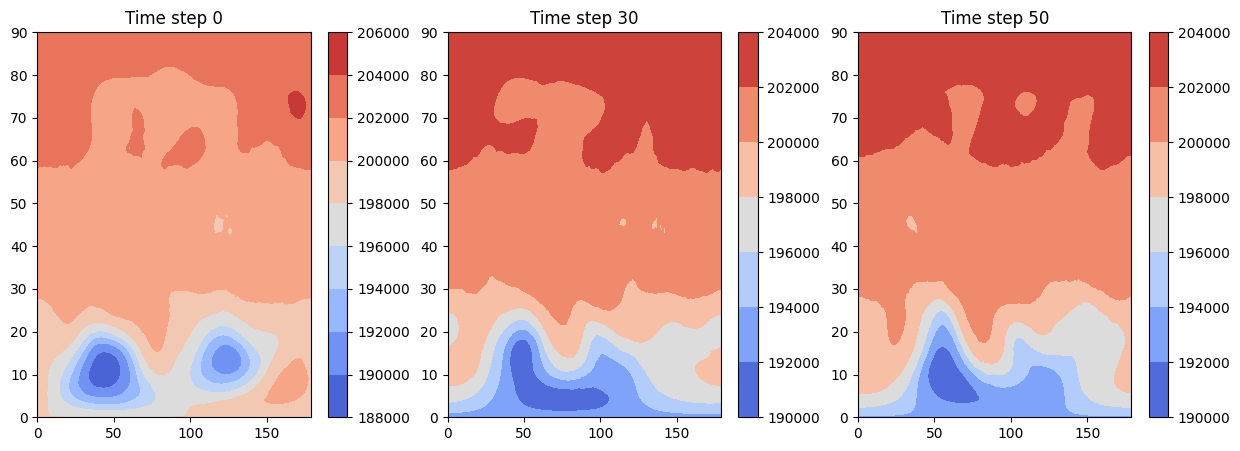

(1460, 2, 91, 180)
(1464, 2, 91, 180)
(1460, 2, 91, 180)
(1460, 2, 91, 180)
(1460, 2, 91, 180)


In [ ]:
!pip install netCDF4
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import netCDF4 as nc

drive.mount('/content/drive')
data_79 = nc.Dataset('/content/drive/MyDrive/Copy of z1979.nc')
data_80 = nc.Dataset('/content/drive/MyDrive/Copy of z1980.nc')
data_81 = nc.Dataset('/content/drive/MyDrive/Copy of z1981.nc')
data_85 = nc.Dataset('/content/drive/MyDrive/Copy of z1985.nc')
data_83 = nc.Dataset('/content/drive/MyDrive/Copy of z1983.nc')

z_data_79 = data_79.variables['z'][:]
z_data_80 = data_80.variables['z'][:]
z_data_81 = data_81.variables['z'][:]
z_data_85 = data_85.variables['z'][:]
z_data_83 = data_83.variables['z'][:]

time_steps = [0, 30, 50]
fig, axes = plt.subplots(1, len(time_steps), figsize=(15, 5))

for i, t in enumerate(time_steps):
    spatial_data = z_data_85[t, 0, :, :]
    ax = axes[i]
    cs = ax.contourf(spatial_data, cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.set_title(f'Time step {t}')

plt.show()
print(data_79.variables['z'][:].shape)
print(data_80.variables['z'][:].shape)
print(data_81.variables['z'][:].shape)
print(data_83.variables['z'][:].shape)
print(data_85.variables['z'][:].shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=None):
        super(VAE, self).__init__()
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.input_height = 91
        self.input_width = 180
        self.encoder = nn.Sequential(
            # 91×180 -> 46×90
            nn.Conv2d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),

            # 46×90 -> 23×45
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.LeakyReLU(0.2),

            # 23×45 -> 12×23
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.LeakyReLU(0.2),

            # 12×23 -> 6×12
            nn.Conv2d(hidden_dim*4, hidden_dim*8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim*8),
            nn.LeakyReLU(0.2),
        ).to(self.device)

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_dim, self.input_height, self.input_width).to(self.device)
            encoded_output = self.encoder(dummy_input)
            self.encoded_h = encoded_output.size(2)
            self.encoded_w = encoded_output.size(3)
            self.encoded_channels = encoded_output.size(1)
            self.flattened_dim = encoded_output.view(1, -1).size(1)
            print(f"Encoded shape: {encoded_output.shape}, Flattened: {self.flattened_dim}")

        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim).to(self.device)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim).to(self.device)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_dim).to(self.device)

        self.decoder = nn.Sequential(
            nn.Conv2d(self.encoded_channels, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.LeakyReLU(0.2),

            # 6×12 -> 12×24 (upscale)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(hidden_dim*4, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.LeakyReLU(0.2),

            # 12×24 -> 23×45 (approximately, will be exact with final resize)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(hidden_dim*4, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.LeakyReLU(0.2),

            # 23×45 -> 46×90 (approximately)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),

            # 46×90 -> 91×180 (approximately)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),

            # Final adjustment to exact output size and channels
            nn.Conv2d(hidden_dim, input_dim, kernel_size=3, padding=1),
            nn.Sigmoid()
        ).to(self.device)

        self.to(self.device)

    def encode(self, x):
        x = x.to(self.device)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-4, max=4)
        std = torch.exp(logvar / 2) + 1e-5
        eps = torch.randn_like(std).to(self.device)
        return mu + eps * std

    def decode(self, z):
        z = z.to(self.device)
        x = self.fc_decode(z)
        batch_size = z.size(0)
        x = x.view(batch_size, self.encoded_channels, self.encoded_h, self.encoded_w)
        x = self.decoder(x)

        if x.size(2) != self.input_height or x.size(3) != self.input_width:
            x = F.interpolate(x, size=(self.input_height, self.input_width),
                             mode='bilinear', align_corners=False)

        return x

    def forward(self, x):
        x = x.to(self.device)
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def corrupt_data(data, k):
  sparse_data = data.clone()
  time, channel, latitude, longitude = sparse_data.shape
  for t in range(time):
    indices1 = np.random.randint(0,latitude,k)
    indices2 = np.random.randint(0,longitude,k)
    for i in range(k):
      sparse_data[t,:,indices1[i],indices2[i]] = 0
  return torch.tensor(sparse_data,dtype=torch.float32)

In [ ]:

train_data = torch.cat([
    torch.tensor(z_data_79, dtype=torch.float32),
    torch.tensor(z_data_80, dtype=torch.float32),
    torch.tensor(z_data_81, dtype=torch.float32),
    torch.tensor(z_data_83, dtype=torch.float32)
], dim=0)
k = int(train_data.shape[0] * 0.9)
test_data = torch.tensor(z_data_85, dtype=torch.float32)

data_mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
data_std = train_data.std(dim=(0, 2, 3), keepdim=True)
train_data_norm = (train_data - data_mean) / (data_std + 1e-6)
test_data_norm = (test_data - data_mean) / (data_std + 1e-6)


train_z = corrupt_data(train_data_norm, k)
test_z = data_85.variables['z'][:]
input_train_z = torch.tensor(train_z, dtype=torch.float32)
label_train_z = torch.tensor(train_data_norm, dtype=torch.float32)



<ipython-input-3-62e521d0f4c9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sparse_data,dtype=torch.float32)
<ipython-input-4-8e6fbab2ad6e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_train_z = torch.tensor(train_z, dtype=torch.float32)
<ipython-input-4-8e6fbab2ad6e>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train_z = torch.tensor(train_data_norm, dtype=torch.float32)


In [ ]:
import torch.optim as optim
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
batch_size = 40
epochs = 30
net = VAE(input_dim=2, hidden_dim=64, latent_dim=128)
net = net.to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()
input_train_z = input_train_z.to(device)
label_train_z = label_train_z.to(device)
trainN = input_train_z.shape[0]
kl_weight_start = 0.0001
kl_weight_end = 0.001
kl_annealing_epochs = 15

for epoch in range(epochs):
    net.train()
    indices = np.random.permutation(trainN)
    epoch_loss = 0

    if epoch < kl_annealing_epochs:
        kl_weight = kl_weight_start + (kl_weight_end - kl_weight_start) * (epoch / kl_annealing_epochs)
    else:
        kl_weight = kl_weight_end

    for step in range(0, trainN, batch_size):
        batch_indices = indices[step:step + batch_size]
        input_batch = input_train_z[batch_indices]
        label_batch = label_train_z[batch_indices]

        optimizer.zero_grad()
        output, mu, logvar = net(input_batch)
        logvar = torch.clamp(logvar, min = -4, max = 4)
        recon_loss = loss_fn(output, label_batch)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / input_batch.size(0)

        #kl_loss = torch.clamp(kl_loss, min=0.1)

        loss_value = recon_loss + kl_weight*kl_loss

        loss_value.backward()
        optimizer.step()

        epoch_loss += loss_value.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/trainN:.4f}, KL Loss: {kl_loss.item():.4f}")

torch.save(net.state_dict(), "net_weights.pth")
torch.save(net, "net_full.pth")

# If you want to load the model later on the same device
def load_model(path):
    loaded_model = VAE(input_dim=2, hidden_dim=64, latent_dim=128)
    loaded_model.load_state_dict(torch.load(path))
    return loaded_model.to(device)

Using device: cuda
Encoded shape: torch.Size([1, 512, 6, 12]), Flattened: 36864
Epoch 1, Loss: 0.0188, KL Loss: 48.1247
Epoch 2, Loss: 0.0179, KL Loss: 59.1985
Epoch 3, Loss: 0.0178, KL Loss: 29.9605
Epoch 4, Loss: 0.0178, KL Loss: 19.6866
Epoch 5, Loss: 0.0178, KL Loss: 19.5075
Epoch 6, Loss: 0.0177, KL Loss: 21.0266
Epoch 7, Loss: 0.0177, KL Loss: 26.5893
Epoch 8, Loss: 0.0177, KL Loss: 13.8497
Epoch 9, Loss: 0.0177, KL Loss: 11.8252
Epoch 10, Loss: 0.0177, KL Loss: 11.4494
Epoch 11, Loss: 0.0177, KL Loss: 11.1616
Epoch 12, Loss: 0.0176, KL Loss: 10.3663
Epoch 13, Loss: 0.0177, KL Loss: 10.6293
Epoch 14, Loss: 0.0177, KL Loss: 9.9276
Epoch 15, Loss: 0.0177, KL Loss: 9.2965
Epoch 16, Loss: 0.0177, KL Loss: 9.2640
Epoch 17, Loss: 0.0177, KL Loss: 9.8989
Epoch 18, Loss: 0.0177, KL Loss: 10.6650
Epoch 19, Loss: 0.0177, KL Loss: 9.2566
Epoch 20, Loss: 0.0177, KL Loss: 7.8168
Epoch 21, Loss: 0.0177, KL Loss: 8.8117
Epoch 22, Loss: 0.0177, KL Loss: 10.2470
Epoch 23, Loss: 0.0177, KL Loss: 8

Using device: cuda
Encoded shape: torch.Size([1, 512, 6, 12]), Flattened: 36864


<ipython-input-3-62e521d0f4c9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sparse_data,dtype=torch.float32)


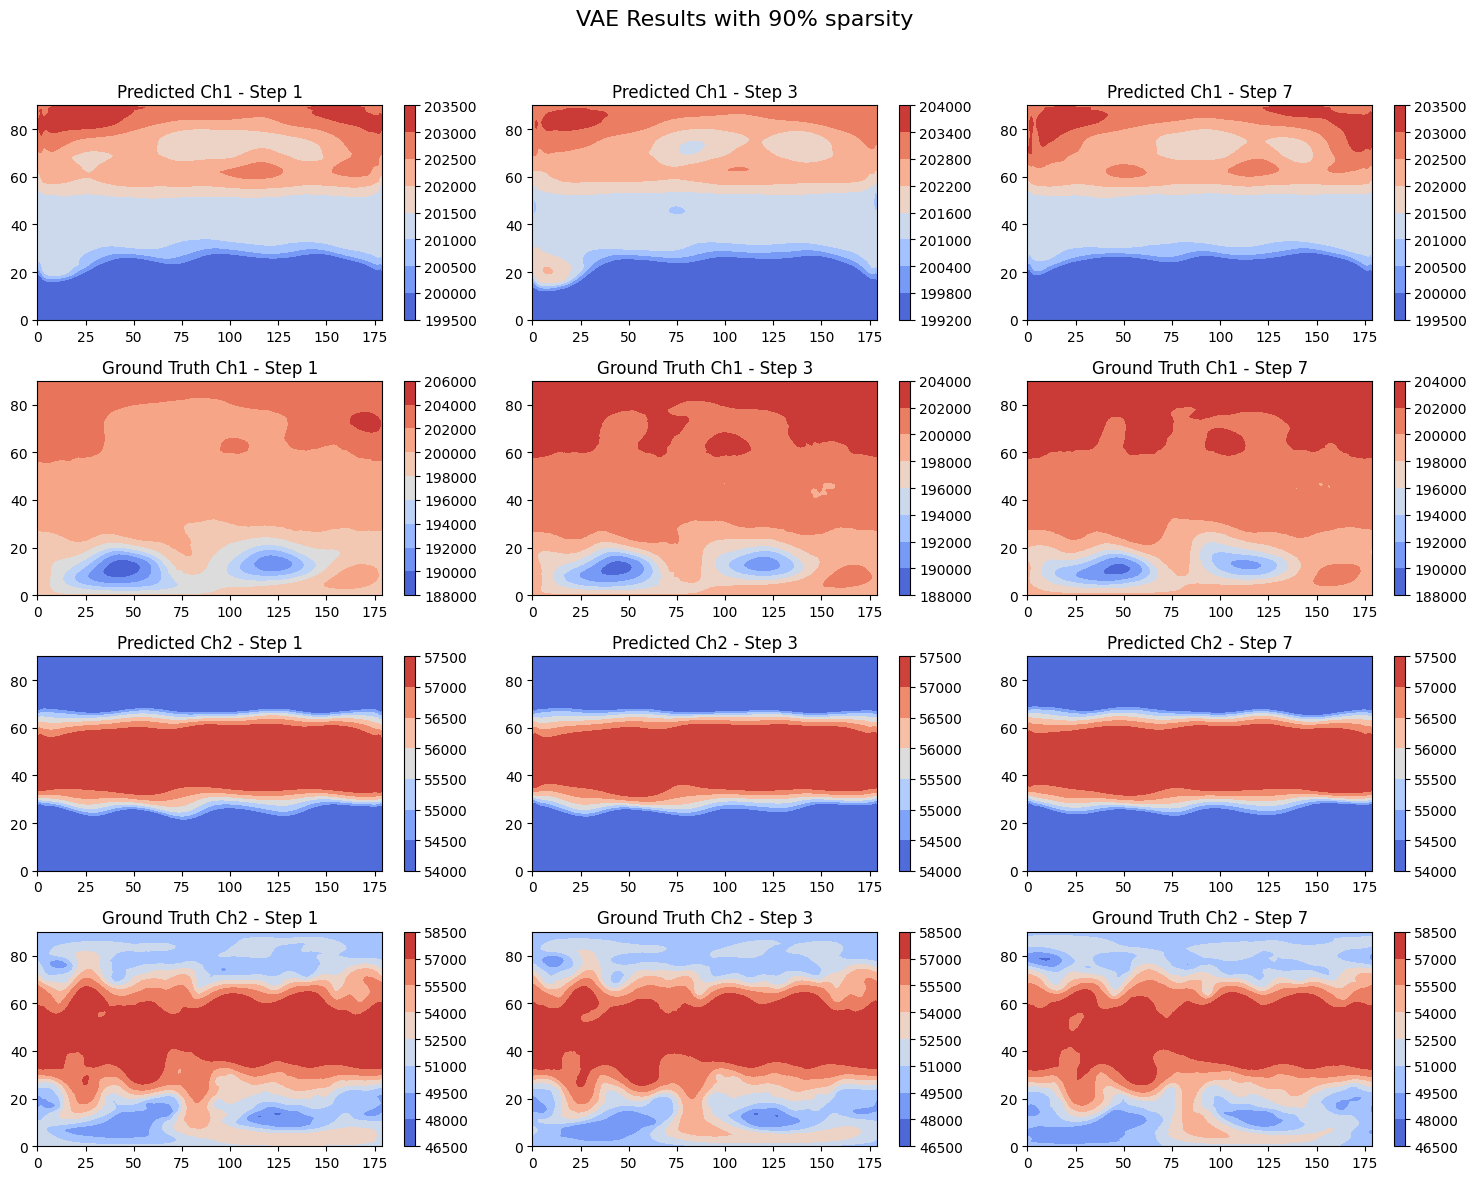

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net_loaded = VAE(input_dim=2, hidden_dim=64, latent_dim=128)
net_loaded.load_state_dict(torch.load("net_weights.pth", map_location=device))
net_loaded = net_loaded.to(device)
net_loaded.eval()

input_85 = corrupt_data(test_data_norm, k)
input_85 = input_85.float().to(device)

with torch.no_grad():
    predicted_85, _, _ = net_loaded(input_85)
    predicted_85 = predicted_85.detach().cpu()

predicted_85_denorm = predicted_85 * data_std + data_mean

spatial_points = test_data.shape[2] * test_data.shape[3]
sparse_percent = (k / spatial_points) * 100

time_steps = [1, 3, 7]

fig, axes = plt.subplots(4, len(time_steps), figsize=(15, 12))
fig.suptitle(f'VAE Results with 90% sparsity', fontsize=16)

for i, t in enumerate(time_steps):
    ax = axes[0, i]
    cs = ax.contourf(predicted_85_denorm[t, 0].numpy(), cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.set_title(f'Predicted Ch1 - Step {t}')

    ax = axes[1, i]
    cs = ax.contourf(test_data[t, 0].numpy(), cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.set_title(f'Ground Truth Ch1 - Step {t}')

    ax = axes[2, i]
    cs = ax.contourf(predicted_85_denorm[t, 1].numpy(), cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.set_title(f'Predicted Ch2 - Step {t}')

    ax = axes[3, i]
    cs = ax.contourf(test_data[t, 1].numpy(), cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.set_title(f'Ground Truth Ch2 - Step {t}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()